# ConvNet et MobileNet
### Exemple avec DenseNet et MobileNetV2

Les exemples seront traitées sur le dataset du Cifar10 qui est une base de données d'images avec 10 classes.

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torchvision.models import densenet121, densenet169, densenet201, mobilenet_v2, mobilenet_v3_large, mobilenet_v3_small
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


#### Import du dataset Cifar10:

In [ ]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create subsets with only 1000 images
train_subset = torch.utils.data.Subset(train_dataset, range(50000))
test_subset = torch.utils.data.Subset(test_dataset,  range(10000))

# Create dataloaders for the subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [02:23<00:00, 1.19MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Définition de fonction de train et test pour la suite :

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## I - DenseNet

### I-1: Une utilisation de DenseNet sans pré-entrainement

In [ ]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 10
batch_size = BATCH_SIZE
# Architecture
NUM_CLASSES = 10

# Other
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
GRAYSCALE = True

In [ ]:
model_dn121 = densenet121(weights=None)
model_dn121.classifier = nn.Linear(model_dn121.classifier.in_features,
                                   NUM_CLASSES,
                                   RANDOM_SEED)  # Assuming 10 classes for CIFAR-10
model_dn121.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dn121.parameters(), lr=LEARNING_RATE)

In [ ]:
epochs = 30
loss_dn121 = []
accuracy_dn121 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_dn121, loss_fn, optimizer)
    test_loop(test_dataloader, model_dn121, loss_fn)
    loss, acc = test_loop(test_dataloader, model_dn121, loss_fn)
    loss_dn121.append(loss)
    accuracy_dn121.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.370697  [  128/50000]
loss: 2.045146  [ 2688/50000]
loss: 1.878132  [ 5248/50000]
loss: 2.339424  [ 7808/50000]
loss: 2.144076  [10368/50000]
loss: 2.295434  [12928/50000]
loss: 1.793012  [15488/50000]
loss: 1.919944  [18048/50000]
loss: 1.707924  [20608/50000]
loss: 1.735181  [23168/50000]
loss: 1.644734  [25728/50000]
loss: 1.722231  [28288/50000]
loss: 1.801603  [30848/50000]
loss: 1.781323  [33408/50000]
loss: 1.746611  [35968/50000]
loss: 1.745039  [38528/50000]
loss: 1.636957  [41088/50000]
loss: 1.633174  [43648/50000]
loss: 1.557319  [46208/50000]
loss: 1.566017  [48768/50000]
Test Error: 
 Accuracy: 43.6%, Avg loss: 1.574218 

Test Error: 
 Accuracy: 43.6%, Avg loss: 1.574218 

Epoch 2
-------------------------------
loss: 1.399247  [  128/50000]
loss: 1.633587  [ 2688/50000]
loss: 1.508136  [ 5248/50000]
loss: 1.428253  [ 7808/50000]
loss: 1.590289  [10368/50000]
loss: 1.630999  [12928/50000]
loss: 1.350441  [15488/50000]
loss: 

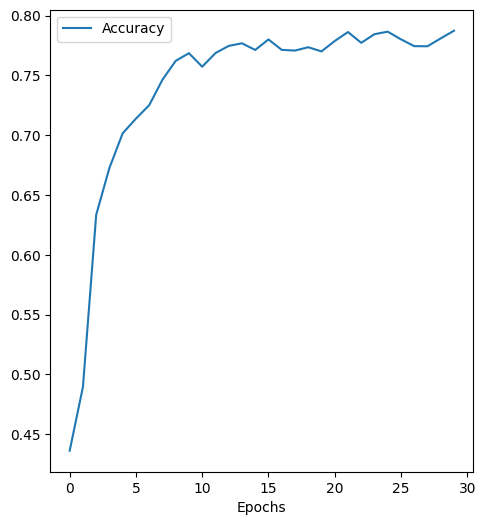

In [ ]:
# Plotting the loss and accuracy for DenseNet models
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
#plt.plot(epochs_range, loss_dn121, label='Loss')
plt.xlabel('Epochs')
plt.plot(epochs_range, accuracy_dn121, label='Accuracy')
plt.legend()

plt.show()

## II - MobileNet

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create subsets with only 1000 images
train_subset = torch.utils.data.Subset(train_dataset, range(50000))
test_subset = torch.utils.data.Subset(test_dataset,  range(10000))

# Create dataloaders for the subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model_mobilenetv2 = mobilenet_v2(weights=None)
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.classifier[1].in_features, NUM_CLASSES)
model_mobilenetv2.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenetv2.parameters(), lr=LEARNING_RATE)

epochs = 10
loss_mobilenetv2 = []
accuracy_mobilenetv2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_mobilenetv2, loss_fn, optimizer)
    test_loop(test_dataloader, model_mobilenetv2, loss_fn)
    loss, acc = test_loop(test_dataloader, model_mobilenetv2, loss_fn)
    loss_mobilenetv2.append(loss)
    accuracy_mobilenetv2.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.415656  [  128/50000]
loss: 2.335080  [ 2688/50000]
loss: 3.263574  [ 5248/50000]
loss: 2.460783  [ 7808/50000]
loss: 2.321138  [10368/50000]
loss: 2.264668  [12928/50000]
loss: 2.764791  [15488/50000]
loss: 2.329873  [18048/50000]
loss: 2.371707  [20608/50000]
loss: 2.325156  [23168/50000]
loss: 2.077771  [25728/50000]
loss: 2.056124  [28288/50000]
loss: 1.993655  [30848/50000]
loss: 2.057141  [33408/50000]
loss: 1.930084  [35968/50000]
loss: 2.129149  [38528/50000]
loss: 1.988136  [41088/50000]
loss: 1.996126  [43648/50000]
loss: 1.843514  [46208/50000]
loss: 2.108479  [48768/50000]
Test Error: 
 Accuracy: 28.1%, Avg loss: 1.942914 

Test Error: 
 Accuracy: 28.2%, Avg loss: 1.941821 

Epoch 2
-------------------------------
loss: 1.847804  [  128/50000]
loss: 1.695741  [ 2688/50000]
loss: 1.778972  [ 5248/50000]
loss: 1.777641  [ 7808/50000]
loss: 1.785901  [10368/50000]
loss: 2.046546  [12928/50000]
loss: 1.664634  [15488/50000]
loss: 

In [ ]:
model_mobilenetv3_large = mobilenet_v3_large(weights=None)
model_mobilenetv3_large.classifier[3] = nn.Linear(out_features=NUM_CLASSES,in_features=1280)  # Assuming 10 classes for CIFAR-10
model_mobilenetv3_large.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenetv3_large.parameters(), lr=LEARNING_RATE)

epochs = 10
loss_mobilenetv3_large = []
accuracy_mobilenetv3_large = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_mobilenetv3_large, loss_fn, optimizer)
    test_loop(test_dataloader, model_mobilenetv3_large, loss_fn)
    loss, acc = test_loop(test_dataloader, model_mobilenetv3_large, loss_fn)
    loss_mobilenetv3_large.append(loss)
    accuracy_mobilenetv3_large.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300653  [  128/50000]
loss: 2.371474  [ 2688/50000]
loss: 2.199153  [ 5248/50000]
loss: 2.150306  [ 7808/50000]
loss: 1.802617  [10368/50000]
loss: 2.125502  [12928/50000]
loss: 1.766372  [15488/50000]
loss: 1.950989  [18048/50000]
loss: 1.849484  [20608/50000]
loss: 1.686296  [23168/50000]
loss: 1.647861  [25728/50000]
loss: 1.693510  [28288/50000]
loss: 1.720284  [30848/50000]
loss: 1.564763  [33408/50000]
loss: 1.718899  [35968/50000]
loss: 1.484588  [38528/50000]
loss: 1.578844  [41088/50000]
loss: 1.498674  [43648/50000]
loss: 1.531131  [46208/50000]
loss: 1.439973  [48768/50000]
Test Error: 
 Accuracy: 15.1%, Avg loss: 7.132427 

Test Error: 
 Accuracy: 15.0%, Avg loss: 7.101413 

Epoch 2
-------------------------------
loss: 1.465783  [  128/50000]
loss: 1.454987  [ 2688/50000]
loss: 1.400469  [ 5248/50000]
loss: 1.305030  [ 7808/50000]
loss: 1.415829  [10368/50000]
loss: 1.291794  [12928/50000]
loss: 1.454449  [15488/50000]
loss: 

In [ ]:
model_mobilenetv3_small = mobilenet_v3_small(weights=None)
model_mobilenetv3_small.classifier[3] = nn.Linear(in_features=1024,out_features=NUM_CLASSES)  # Assuming 10 classes for CIFAR-10
model_mobilenetv3_small.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenetv3_small.parameters(), lr=LEARNING_RATE)

epochs = 10
loss_mobilenetv3_small = []
accuracy_mobilenetv3_small = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_mobilenetv3_small, loss_fn, optimizer)
    test_loop(test_dataloader, model_mobilenetv3_small, loss_fn)
    loss, acc = test_loop(test_dataloader, model_mobilenetv3_small, loss_fn)
    loss_mobilenetv3_small.append(loss)
    accuracy_mobilenetv3_small.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301596  [  128/50000]
loss: 2.197764  [ 2688/50000]
loss: 1.937076  [ 5248/50000]
loss: 1.764007  [ 7808/50000]
loss: 1.820856  [10368/50000]
loss: 1.720289  [12928/50000]
loss: 1.893715  [15488/50000]
loss: 1.812362  [18048/50000]
loss: 1.765562  [20608/50000]
loss: 1.726861  [23168/50000]
loss: 1.621268  [25728/50000]
loss: 1.545399  [28288/50000]
loss: 1.828655  [30848/50000]
loss: 1.573990  [33408/50000]
loss: 1.575419  [35968/50000]
loss: 1.672219  [38528/50000]
loss: 1.741756  [41088/50000]
loss: 1.397765  [43648/50000]
loss: 1.333671  [46208/50000]
loss: 1.490400  [48768/50000]
Test Error: 
 Accuracy: 27.1%, Avg loss: 4.222441 

Test Error: 
 Accuracy: 27.0%, Avg loss: 4.230364 

Epoch 2
-------------------------------
loss: 1.703231  [  128/50000]
loss: 1.127408  [ 2688/50000]
loss: 1.349040  [ 5248/50000]
loss: 1.357912  [ 7808/50000]
loss: 1.312191  [10368/50000]
loss: 1.240254  [12928/50000]
loss: 1.246320  [15488/50000]
loss: 

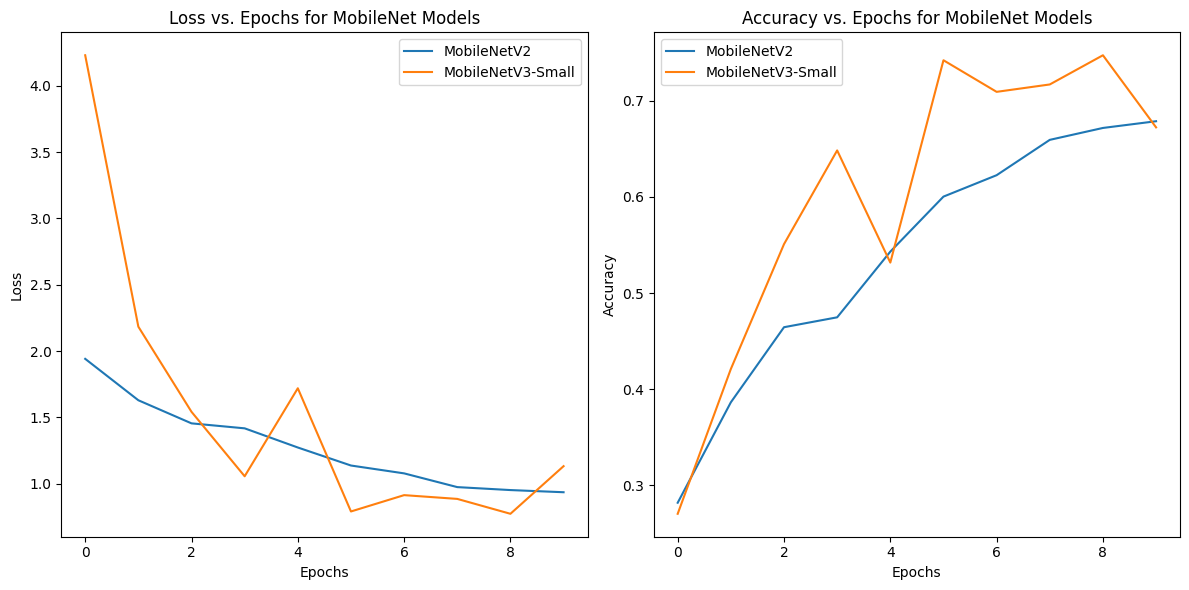

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_mobilenetv2, label='MobileNetV2')
plt.plot(epochs_range, loss_mobilenetv3_small, label='MobileNetV3-Small')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs for MobileNet Models')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy_mobilenetv2, label='MobileNetV2')
plt.plot(epochs_range, accuracy_mobilenetv3_small, label='MobileNetV3-Small')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs for MobileNet Models')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()